Developed a machine learning model to predict the busyness of taxi zones in Manhattan. The training dataset has both the taxi and subway riderships. both values are combined using natural log transformation to formulate the target_variable according to the formula:


$$
\text{busyness_score} = \ln(\frac{\text{taxi_ridership} \times \left(1 + \text{subway_ridership}\right)}{\text{zone_area}})
$$


Results of the XGBoost Model (average of 5 folds of cross validation):

- Average Mean Squared Error (MSE): 0.17
- Average Root Mean Squared Error (RMSE): 0.41
- Average R-squared (R2): 0.99
- Average Mean Absolute Error (MAE): 0.27
- Relative RMSE (as a percentage of mean): 4.70%
- Relative RMSE (as a percentage of median): 4.49%

This script generates a pickle file `xgboost_busyness_model.pkl` and it has a sample code for running the model to predict a future value, and a color coded map for visualisation!

In [1]:
import json
from shapely.geometry import shape, Point
import os
# !pip install python-dotenv
from dotenv import load_dotenv
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
# !pip install optuna
import optuna
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import branca.colormap as cm

In [2]:
load_dotenv('/content/.env')

False

In [3]:
# # Download the file from Google Drive using the file ID
# !gdown {os.getenv('combined-taxi-subway-data')}
# !gdown {os.getenv('taxi-geojason')}

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'gdown' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
cwd = os.getcwd()
data_dir = os.path.join(os.getcwd(), "..", "Datasets", "taxi_other")
print(f"Data directory: {data_dir}")

# Check if the directory exists
if not os.path.exists(data_dir):
    print(f"Directory {data_dir} does not exist")
    cwd = os.getcwd()

print("Current Working Directory:", cwd)

# Define the file paths relative to the data directory
df_path = os.path.join(data_dir, "taxi_subway_zones_df.csv")

# Print the constructed file paths to verify
print("busyness_df:", df_path)

# Read the CSV using the correct datetime format
df = pd.read_csv(df_path)


df.head()

Data directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis\..\Datasets\taxi_other
Current Working Directory: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis
busyness_df: c:\Users\35385\Desktop\CS_Summer_2024\Shared_GH\New-York-App\data-analytics\analysis\..\Datasets\taxi_other\taxi_subway_zones_df.csv


,transit_timestamp,zone_id,taxi_ridership,subway_ridership,subway_station_present,zone_area_m2
0,2022-02-01 00:00:00,4,20,0,False,1.740161e+06
1,2022-02-01 00:00:00,12,1,0,False,2.365054e+05
2,2022-02-01 00:00:00,13,23,0,False,1.068199e+06
3,2022-02-01 00:00:00,24,20,25,True,9.145472e+05
4,2022-02-01 00:00:00,41,32,154,True,3.120089e+06


In [6]:
#add a total ridership column.
df['total_ridership'] = df['taxi_ridership'] + df['subway_ridership']

In [7]:
#change zone area from m2 to km2
df['zone_area_km2'] = df['zone_area_m2'] / 1000000

#drop zone_area_m2 column
df = df.drop('zone_area_m2', axis=1)

In [8]:
#preview the df
df.head()

,transit_timestamp,zone_id,taxi_ridership,subway_ridership,subway_station_present,total_ridership,zone_area_km2
0,2022-02-01 00:00:00,4,20,0,False,20,1.740161
1,2022-02-01 00:00:00,12,1,0,False,1,0.236505
2,2022-02-01 00:00:00,13,23,0,False,23,1.068199
3,2022-02-01 00:00:00,24,20,25,True,45,0.914547
4,2022-02-01 00:00:00,41,32,154,True,186,3.120089


In [9]:
#get the max timestamp in the dataframe
max_timestamp = df['transit_timestamp'].max()

max_timestamp

'2024-04-01 00:00:00'

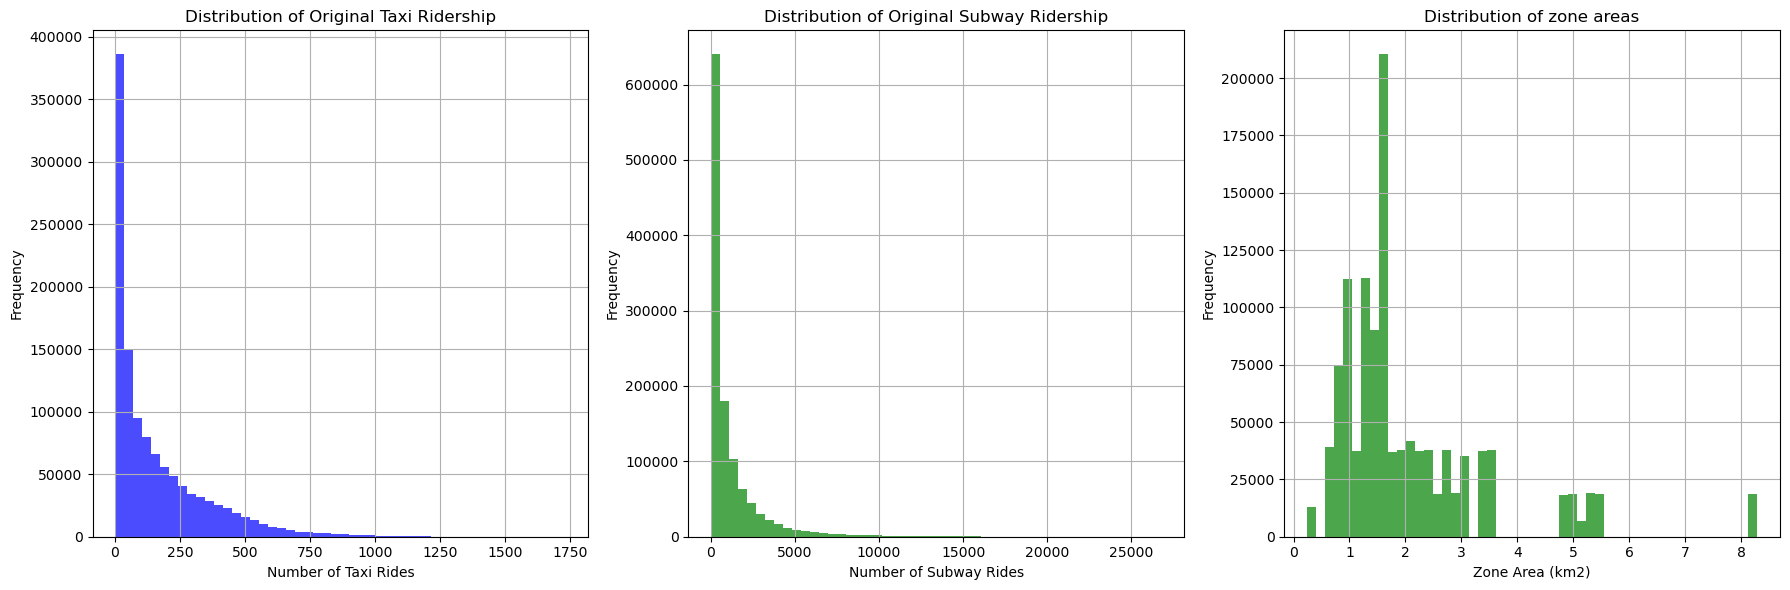

In [10]:
# Plotting the distribution of original taxi ridership
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.hist(df['taxi_ridership'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Original Taxi Ridership')
plt.xlabel('Number of Taxi Rides')
plt.ylabel('Frequency')
plt.grid(True)


# Plotting the distribution of original subway ridership
plt.subplot(1, 3, 2)
plt.hist(df['subway_ridership'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Original Subway Ridership')
plt.xlabel('Number of Subway Rides')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(df['zone_area_km2'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of zone areas')
plt.xlabel('Zone Area (km2)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.grid(True)
plt.show()


Text(0, 0.5, 'Frequency')

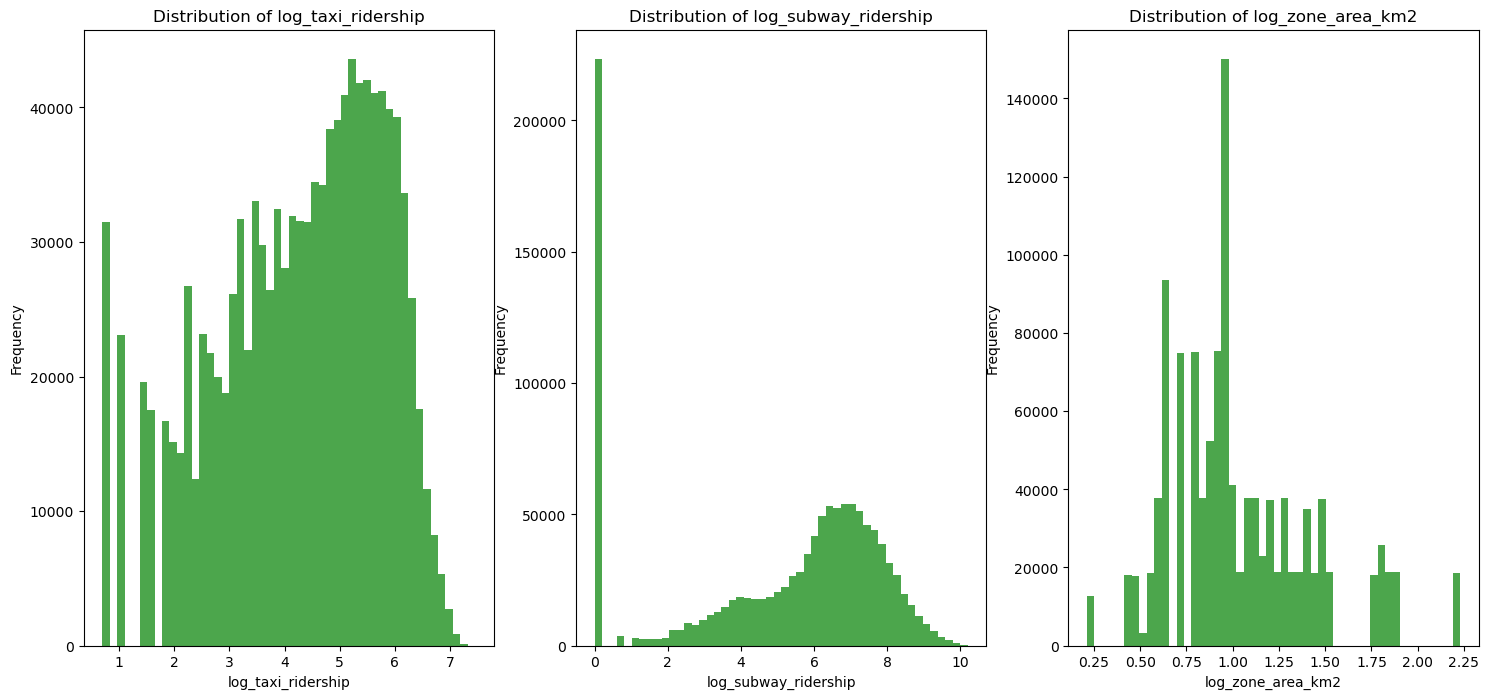

In [11]:
#log transform taxi and subway riderships
df['log_taxi_ridership'] = np.log1p(df['taxi_ridership'])
df['log_subway_ridership'] = np.log1p(df['subway_ridership'])
df['log_zone_area_km2'] = np.log1p(df['zone_area_km2'])

plt.figure(figsize=(18, 8))

# Plotting the distribution of log-transformed subway ridership with imputed values
plt.subplot(1, 3, 1)
plt.hist(df['log_taxi_ridership'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of log_taxi_ridership')
plt.xlabel('log_taxi_ridership')
plt.ylabel('Frequency')

# Plotting the distribution of log-transformed subway ridership with imputed values
plt.subplot(1, 3, 2)
plt.hist(df['log_subway_ridership'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of log_subway_ridership')
plt.xlabel('log_subway_ridership')
plt.ylabel('Frequency')

# Plotting the distribution of log-transformed subway ridership with imputed values
plt.subplot(1, 3, 3)
plt.hist(df['log_zone_area_km2'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of log_zone_area_km2')
plt.xlabel('log_zone_area_km2')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

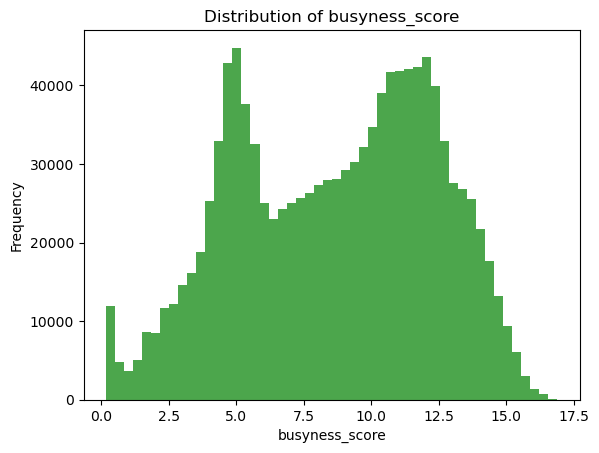

In [12]:
df['busyness_score'] = (df['taxi_ridership']*(1+df['subway_ridership']))/(df['zone_area_km2'])
df['log_busyness_score'] = np.log1p(df['busyness_score'])

# Plotting the distribution of log-transformed subway ridership with imputed values
plt.hist(df['log_busyness_score'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of busyness_score')
plt.xlabel('busyness_score')
plt.ylabel('Frequency')


In [13]:
# Create time-based features
df['transit_timestamp'] = pd.to_datetime(df['transit_timestamp'])
df['hour'] = df['transit_timestamp'].dt.hour
df['day'] = df['transit_timestamp'].dt.day
df['weekday'] = df['transit_timestamp'].dt.weekday
df['month'] = df['transit_timestamp'].dt.month
df['year'] = df['transit_timestamp'].dt.year
df['week'] = df['transit_timestamp'].dt.isocalendar().week
df['is_weekend'] = df['weekday'] >= 5
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~df['is_weekend']

# Define the range of years in the dataset
min_year = df['year'].min()
max_year = df['year'].max()

# Create cyclic features for hour, month, week, and year
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 31)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 31)
df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
df['year_sin'] = np.sin(2 * np.pi * (df['year'] - min_year) / (max_year - min_year + 1))
df['year_cos'] = np.cos(2 * np.pi * (df['year'] - min_year) / (max_year - min_year + 1))

# Calculate rolling averages and lags on the original data

# Create rolling and lagged features with grouping by 'zone_id'
df['rolling_mean_24h'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(1).rolling(window=24).mean())
df['rolling_std_24h'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(1).rolling(window=24).std())
df['rolling_mean_7d'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(1).rolling(window=24*7).mean())
df['rolling_std_7d'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(1).rolling(window=24*7).std())

# Lagged features with grouping by 'zone_id'
df['lag_1h'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(1))
df['lag_24h'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(24))
df['lag_7d'] = df.groupby('zone_id')['log_busyness_score'].transform(lambda x: x.shift(24*7))

#fill NaN values with the the last observed value

df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
df['rolling_std_24h'].fillna(method='ffill', inplace=True)
df['rolling_mean_7d'].fillna(method='ffill', inplace=True)
df['rolling_std_7d'].fillna(method='ffill', inplace=True)

df['lag_1h'].fillna(method='ffill', inplace=True)
df['lag_24h'].fillna(method='ffill', inplace=True)
df['lag_7d'].fillna(method='ffill', inplace=True)


# Drop rows with NaN values
df.dropna(inplace=True)

# Apply log transformation to these features if necessary
df['log_rolling_mean_24h'] = np.log1p(df['rolling_mean_24h'])
df['log_rolling_std_24h'] = np.log1p(df['rolling_std_24h'])
df['log_rolling_mean_7d'] = np.log1p(df['rolling_mean_7d'])
df['log_rolling_std_7d'] = np.log1p(df['rolling_std_7d'])
df['log_lag_1h'] = np.log1p(df['lag_1h'])
df['log_lag_24h'] = np.log1p(df['lag_24h'])
df['log_lag_7d'] = np.log1p(df['lag_7d'])

# Ensure that the dataframe is in chronological order
df = df.sort_values(by='transit_timestamp').reset_index(drop=True)


C:\Users\35385\AppData\Local\Temp\ipykernel_16064\494865960.py:45: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_16064\494865960.py:45: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['rolling_mean_24h'].fillna(method='ffill', inplace=True)
C:\Users\35385\AppData\Local\Temp\ipykernel_16064\494865960.py:46: FutureWarning: A value is tryi

In [14]:
df.head()

,transit_timestamp,zone_id,taxi_ridership,subway_ridership,subway_station_present,total_ridership,zone_area_km2,log_taxi_ridership,log_subway_ridership,log_zone_area_km2,...,lag_1h,lag_24h,lag_7d,log_rolling_mean_24h,log_rolling_std_24h,log_rolling_mean_7d,log_rolling_std_7d,log_lag_1h,log_lag_24h,log_lag_7d
0,2022-02-08,42,23,47,True,70,5.488037,3.178054,3.871201,1.869960,...,5.763936,5.516697,5.410155,2.089958,1.101046,2.096872,1.052392,1.911605,1.874368,1.857883
1,2022-02-08,163,70,207,True,277,0.892832,4.262680,5.337538,0.638074,...,11.132082,8.699309,9.773427,2.464252,1.342141,2.476710,1.265912,2.495853,2.272055,2.377083
2,2022-02-08,164,77,514,True,591,1.216774,4.356709,6.244167,0.796053,...,11.137538,9.481902,10.392279,2.504502,1.345954,2.534375,1.169668,2.496303,2.349650,2.432936
3,2022-02-08,166,29,56,True,85,3.442330,3.401197,4.043051,1.491179,...,7.066475,1.874800,6.105622,2.131693,1.481302,2.023280,1.428729,2.087717,1.055983,1.960886
4,2022-02-08,170,99,0,False,99,1.625475,4.605170,0.000000,0.965262,...,4.611780,4.020935,3.813191,1.731206,0.842106,1.759537,0.792482,1.724868,1.613616,1.571360


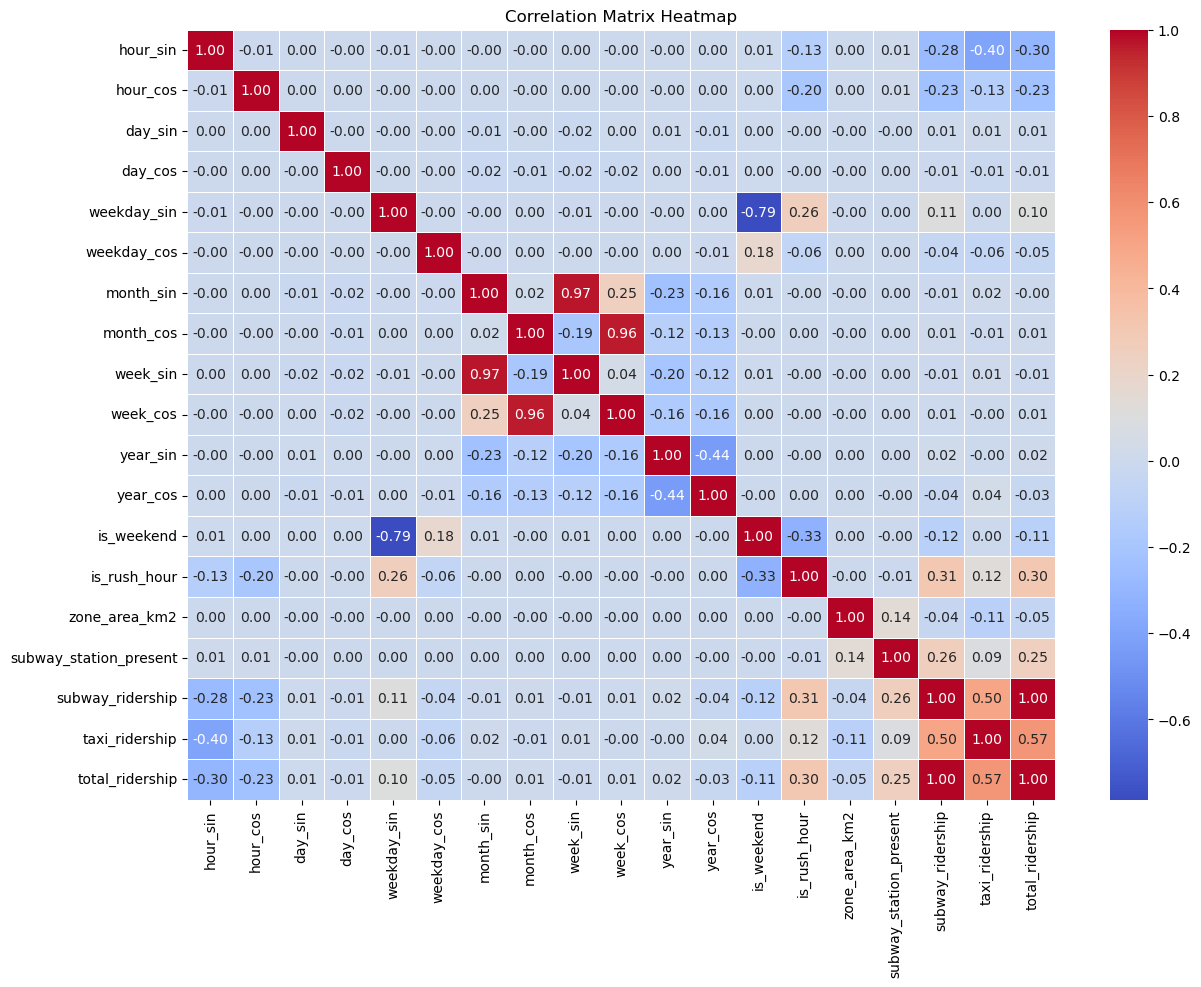

In [15]:
# Compute the correlation matrix
features_corr = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present', 'subway_ridership', 'taxi_ridership'
]
all_columns = features_corr + ['total_ridership']
correlation_matrix = df[all_columns].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['total_ridership'].sort_values(ascending=False)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


In [16]:
# Ensure that the dataframe is in chronological order
df = df.sort_values(by='transit_timestamp').reset_index(drop=True)

# Define features and target
features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present',
    'log_rolling_mean_24h', 'log_rolling_std_24h', 'log_rolling_mean_7d', 'log_rolling_std_7d',
    'log_lag_1h', 'log_lag_24h', 'log_lag_7d'
]

X = df[features + ['zone_id']]
y = df['log_busyness_score']

log_busyness_score        1.000000
log_lag_1h                0.922739
log_lag_24h               0.907935
log_lag_7d                0.862129
log_rolling_mean_24h      0.777140
log_rolling_mean_7d       0.772075
log_rolling_std_7d        0.677708
log_rolling_std_24h       0.654876
subway_station_present    0.613731
zone_id                   0.206559
is_rush_hour              0.189850
weekday_sin               0.010640
day_sin                   0.007640
year_sin                  0.007123
year_cos                  0.002722
week_sin                 -0.000533
month_sin                -0.000792
day_cos                  -0.008683
month_cos                -0.009316
week_cos                 -0.009424
is_weekend               -0.018102
weekday_cos              -0.039809
zone_area_km2            -0.103190
hour_cos                 -0.244812
hour_sin                 -0.353658
Name: log_busyness_score, dtype: float64


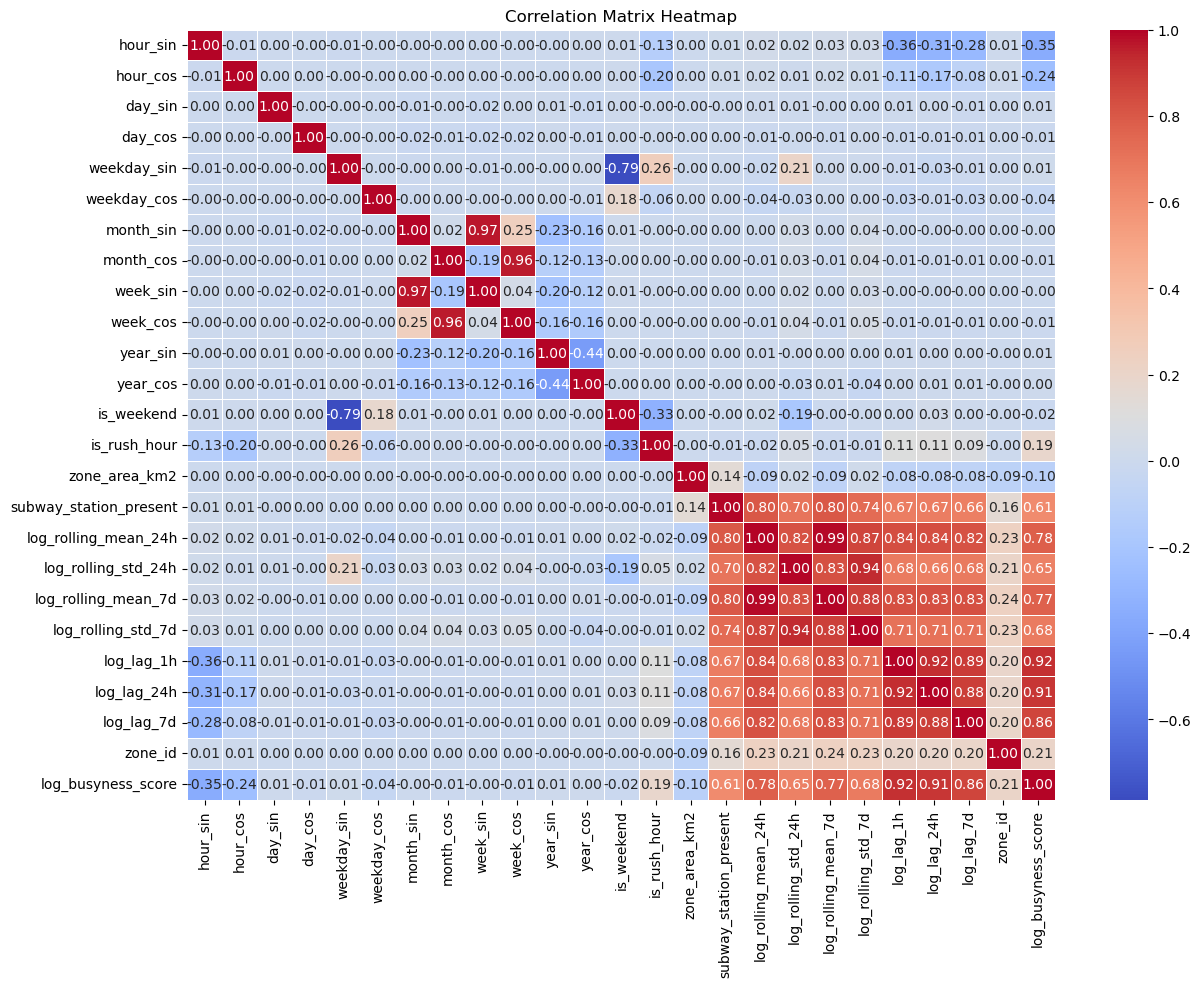

In [17]:
# Compute the correlation matrix

all_columns = features + ['zone_id'] + ['log_busyness_score']
correlation_matrix = df[all_columns].corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix['log_busyness_score'].sort_values(ascending=False)

# Display the correlation with the target variable
print(correlation_with_target)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

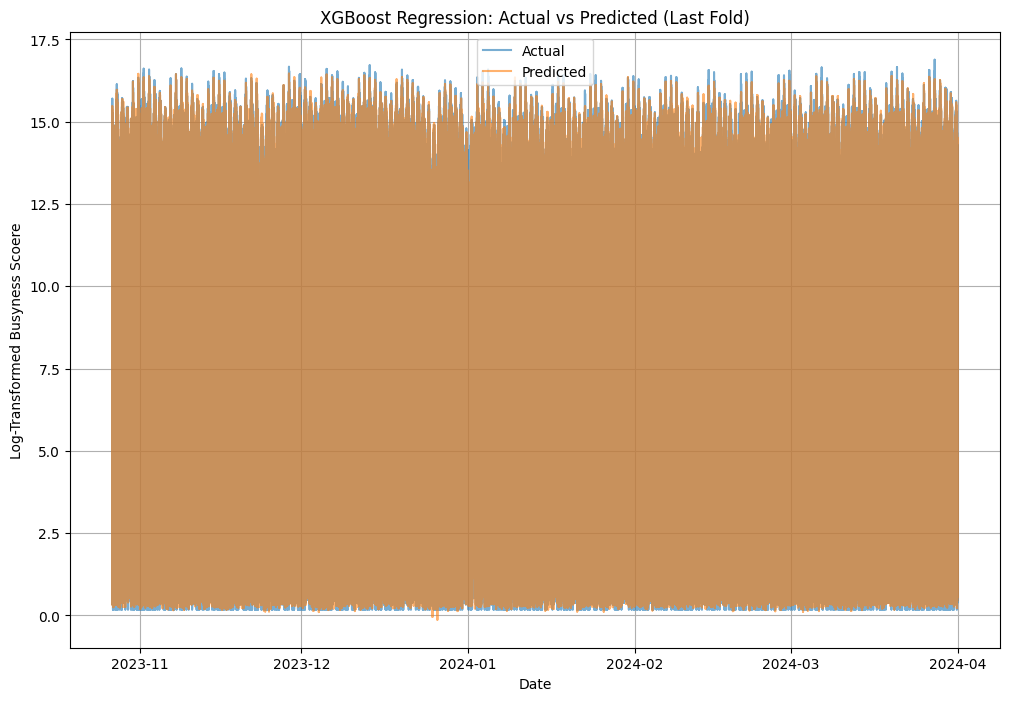

Average Mean Squared Error (MSE): 0.17
Average Root Mean Squared Error (RMSE): 0.41
Average R-squared (R2): 0.99
Average Mean Absolute Error (MAE): 0.27


In [ ]:
# One-hot encode the 'zone_id' feature
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features),
        ('cat', OneHotEncoder(), ['zone_id'])
    ])

# Create a pipeline that scales features and trains the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=362,
        learning_rate=0.12912411467580226,
        max_depth=10,
        subsample=0.9620454248709411,
        colsample_bytree=0.8287274232003768,
        min_child_weight=5,
        reg_alpha=0.23532591326140717,
        reg_lambda=0.4725786342513321,
        random_state=42))
])

# Initialize KFold cross-validation
kf = KFold(n_splits=5, shuffle=False)

# Arrays to store performance metrics for each fold
mse_list = []
rmse_list = []
r2_list = []
mae_list = []

# Loop through each fold
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the pipeline
    pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    r2_list.append(r2)
    mae_list.append(mae)

    # Plotting predictions vs actual for the last fold
    if len(mse_list) == kf.get_n_splits():
        plt.figure(figsize=(12, 8))
        plt.plot(df['transit_timestamp'].iloc[test_index], y_test, label='Actual', alpha=0.6)
        plt.plot(df['transit_timestamp'].iloc[test_index], y_pred, label='Predicted', alpha=0.6)
        plt.xlabel('Date')
        plt.ylabel('Log-Transformed Busyness Scoere')
        plt.title('XGBoost Regression: Actual vs Predicted (Last Fold)')
        plt.legend()
        plt.grid(True)
        plt.show()

# Print average metrics across all folds
print(f'Average Mean Squared Error (MSE): {np.mean(mse_list):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_list):.2f}')
print(f'Average R-squared (R2): {np.mean(r2_list):.2f}')
print(f'Average Mean Absolute Error (MAE): {np.mean(mae_list):.2f}')


In [ ]:
mean_target_variable = df['log_busyness_score'].mean()
std_target_variable = df['log_busyness_score'].std()
median_target_variable = df['log_busyness_score'].median()

# RMSE value
rmse = np.mean(rmse_list)

# Relative RMSE
relative_rmse_mean = (rmse / mean_target_variable) * 100
relative_rmse_median = (rmse / median_target_variable) * 100


print(f"Relative RMSE (as a percentage of mean): {relative_rmse_mean:.2f}%")
print(f"Relative RMSE (as a percentage of median): {relative_rmse_median:.2f}%")

Relative RMSE (as a percentage of mean): 4.70%
Relative RMSE (as a percentage of median): 4.49%


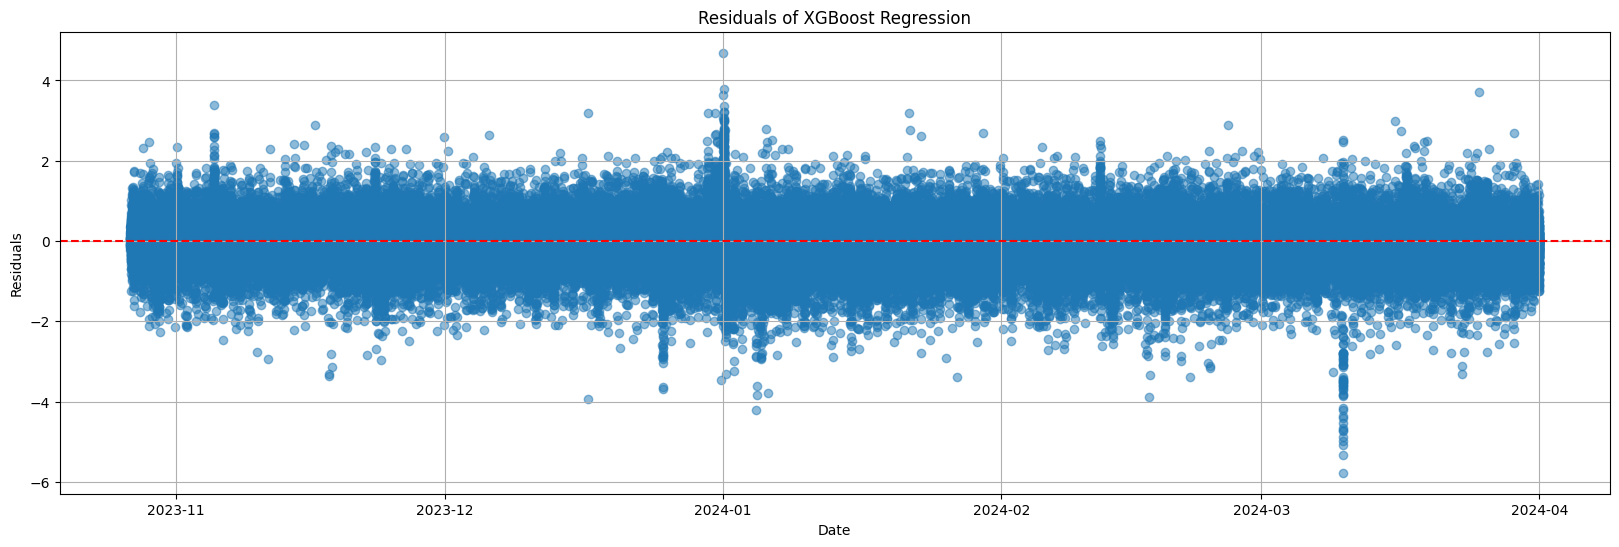

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(20, 6))

plt.scatter(df['transit_timestamp'].iloc[test_index], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.title('Residuals of XGBoost Regression')
plt.grid(True)
plt.show()

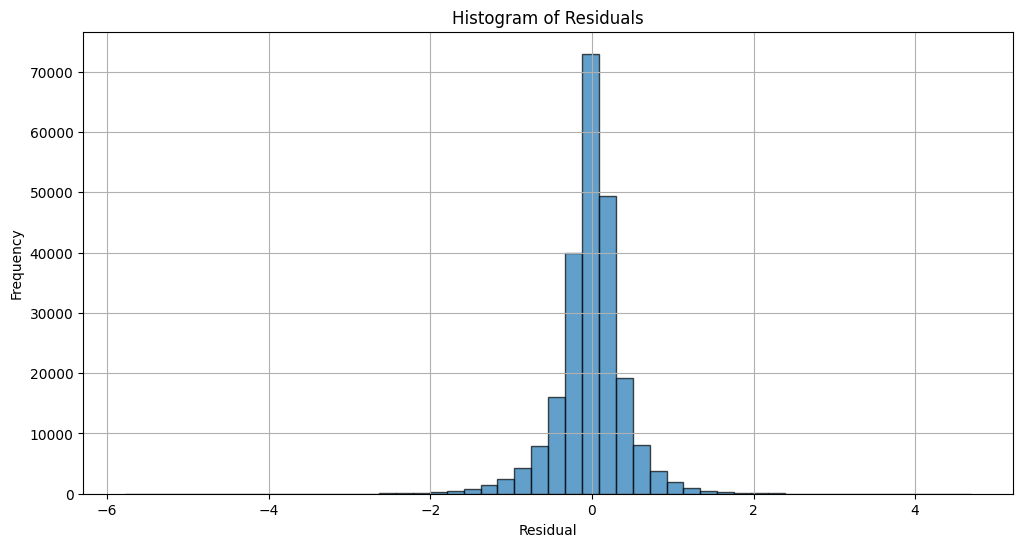

In [ ]:
# Plot the histogram of the residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
#export the model to a pickle file
with open('xgboost_busyness_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [ ]:
#export combined df to csv wthout index
future_df.to_csv('future_df.csv', index=False)

In [ ]:
zones_df = df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()
zones_df.to_csv('zones_df.csv', index=False)

In [ ]:
latest_data = df[df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
latest_data.to_csv('latest_historical_data.csv', index=False)

In [ ]:
prediction_time = '2024-04-02 22:00:00'


# Load the model from a pickle file
with open('xgboost_busyness_model.pkl', 'rb') as f:
    pipeline = pickle.load(f)


# Define the date for prediction
start_date = pd.Timestamp('2024-04-01 00:00:00') #last time recorded in the dataset.
end_date = pd.Timestamp(prediction_time) #the time when we are interested to make a prediction.

#this is the rane of timestamps for which the model will be run.
date_range = pd.date_range(start=start_date + pd.Timedelta(hours=1), end=end_date, freq='H')


# zones_df = df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()

zones_df = pd.read_csv('./zones_df.csv')

#return the zone_ids from zones_df and save them in a list
zones = zones_df['zone_id'].tolist()

#construct the time and zone columns and add them to the future_df
future_df = pd.DataFrame([(zone, date) for zone in zones for date in date_range], columns=['zone_id', 'transit_timestamp'])

# Merge the zones_df to include subway_station_present in future_df
future_df = future_df.merge(zones_df, on='zone_id', how='left')

# Create time-based features for the future dates
future_df['hour'] = future_df['transit_timestamp'].dt.hour
future_df['day'] = future_df['transit_timestamp'].dt.day
future_df['weekday'] = future_df['transit_timestamp'].dt.weekday
future_df['month'] = future_df['transit_timestamp'].dt.month
future_df['year'] = future_df['transit_timestamp'].dt.year
future_df['week'] = future_df['transit_timestamp'].dt.isocalendar().week
future_df['is_weekend'] = future_df['weekday'] >= 5
future_df['is_rush_hour'] = future_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~future_df['is_weekend']

# Create cyclic features for hour, month, week, and year
min_year = 2022
max_year = max(2024,end_date.year)

future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)
future_df['weekday_sin'] = np.sin(2 * np.pi * future_df['weekday'] / 7)
future_df['weekday_cos'] = np.cos(2 * np.pi * future_df['weekday'] / 7)
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
future_df['week_sin'] = np.sin(2 * np.pi * future_df['week'] / 52)
future_df['week_cos'] = np.cos(2 * np.pi * future_df['week'] / 52)
future_df['year_sin'] = np.sin(2 * np.pi * (future_df['year'] - min_year) / (max_year - min_year + 1))
future_df['year_cos'] = np.cos(2 * np.pi * (future_df['year'] - min_year) / (max_year - min_year + 1))


# Initialize columns for rolling and lagged features
rolling_features = ['rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d']
lagged_features = ['lag_1h', 'lag_24h', 'lag_7d']
log_features = ['log_' + feat for feat in rolling_features + lagged_features]

# fill the values with NaN initially.
for feat in rolling_features + lagged_features + log_features:
    future_df[feat] = np.nan

# Copy the latest available rolling and lagged feature values to the future DataFrame
# latest_data = df[df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
latest_data = pd.read_csv('./latest_historical_data.csv')
latest_data['transit_timestamp'] = pd.to_datetime(latest_data['transit_timestamp'])
# Prepend latest_data to future_df
combined_df = pd.concat([latest_data, future_df], ignore_index=True)

# Sort by 'transit_timestamp' to ensure correct order
combined_df = combined_df.sort_values(by='transit_timestamp').reset_index(drop=True)

features = [
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
    'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present',
    'log_rolling_mean_24h', 'log_rolling_std_24h', 'log_rolling_mean_7d', 'log_rolling_std_7d',
    'log_lag_1h', 'log_lag_24h', 'log_lag_7d'
]

future_df = combined_df.copy()


future_df.drop(['total_ridership', 'subway_ridership', 'taxi_ridership','log_taxi_ridership','log_subway_ridership','log_zone_area_km2','busyness_score'], axis=1, inplace=True)


# Iterate through the date range and fill missing data
for date in date_range:
    for zone in zones:
        # zone_df = future_df[future_df['zone_id'] == zone]
        # current_idx = (future_df['zone_id'] == zone) & (future_df['transit_timestamp'] <= date)
        zone_df = future_df[(future_df['zone_id'] == zone) & (future_df['transit_timestamp'] <= date)]
        current_idx = (future_df['zone_id'] == zone) & (future_df['transit_timestamp'] == date)
        # Update rolling and lagged features
        future_df.loc[current_idx, 'rolling_mean_24h'] = zone_df['log_busyness_score'].shift(1).rolling(window=24).mean().iloc[-1]
        future_df.loc[current_idx, 'rolling_std_24h'] = zone_df['log_busyness_score'].shift(1).rolling(window=24).std().iloc[-1]
        future_df.loc[current_idx, 'rolling_mean_7d'] = zone_df['log_busyness_score'].shift(1).rolling(window=24*7).mean().iloc[-1]
        future_df.loc[current_idx, 'rolling_std_7d'] = zone_df['log_busyness_score'].shift(1).rolling(window=24*7).std().iloc[-1]
        future_df.loc[current_idx, 'lag_1h'] = zone_df['log_busyness_score'].shift(1).iloc[-1]
        future_df.loc[current_idx, 'lag_24h'] = zone_df['log_busyness_score'].shift(24).iloc[-1]
        future_df.loc[current_idx, 'lag_7d'] = zone_df['log_busyness_score'].shift(24*7).iloc[-1]

        # Apply log transformation
        future_df.loc[current_idx, 'log_rolling_mean_24h'] = np.log1p(future_df.loc[current_idx, 'rolling_mean_24h'])
        future_df.loc[current_idx, 'log_rolling_std_24h'] = np.log1p(future_df.loc[current_idx, 'rolling_std_24h'])
        future_df.loc[current_idx, 'log_rolling_mean_7d'] = np.log1p(future_df.loc[current_idx, 'rolling_mean_7d'])
        future_df.loc[current_idx, 'log_rolling_std_7d'] = np.log1p(future_df.loc[current_idx, 'rolling_std_7d'])
        future_df.loc[current_idx, 'log_lag_1h'] = np.log1p(future_df.loc[current_idx, 'lag_1h'])
        future_df.loc[current_idx, 'log_lag_24h'] = np.log1p(future_df.loc[current_idx, 'lag_24h'])
        future_df.loc[current_idx, 'log_lag_7d'] = np.log1p(future_df.loc[current_idx, 'lag_7d'])

        # Prepare features for the current date
        X_current = future_df.loc[current_idx, features + ['zone_id']]
        X_current_transformed = pipeline.named_steps['preprocessor'].transform(X_current)
        y_current_pred = pipeline.named_steps['model'].predict(X_current_transformed)
        future_df.loc[current_idx, 'log_busyness_score'] = y_current_pred


In [ ]:
def make_predictions(prediction_time,path_to_pickle_file, path_to_zones_csv, path_to_latest_historical_data_csv):

    '''
    this functions returns a pandas dataframe with the predictions for the specified time for all taxi zones.
    make sure to import pickle, pandas as pd and numpy as np

    '''

    # prediction_time = '2024-04-02 08:00:00'


    # Load the model from a pickle file
    with open(path_to_pickle_file, 'rb') as f:
        pipeline = pickle.load(f)


    # Define the date for prediction
    start_date = pd.Timestamp('2024-04-01 00:00:00') #last time recorded in the dataset.
    end_date = pd.Timestamp(prediction_time) #the time when we are interested to make a prediction.

    #this is the rane of timestamps for which the model will be run.
    date_range = pd.date_range(start=start_date + pd.Timedelta(hours=1), end=end_date, freq='H')


    # zones_df = df[['zone_id', 'subway_station_present','zone_area_km2']].drop_duplicates()

    zones_df = pd.read_csv(path_to_zones_csv)

    #return the zone_ids from zones_df and save them in a list
    zones = zones_df['zone_id'].tolist()

    #construct the time and zone columns and add them to the future_df
    future_df = pd.DataFrame([(zone, date) for zone in zones for date in date_range], columns=['zone_id', 'transit_timestamp'])

    # Merge the zones_df to include subway_station_present in future_df
    future_df = future_df.merge(zones_df, on='zone_id', how='left')

    # Create time-based features for the future dates
    future_df['hour'] = future_df['transit_timestamp'].dt.hour
    future_df['day'] = future_df['transit_timestamp'].dt.day
    future_df['weekday'] = future_df['transit_timestamp'].dt.weekday
    future_df['month'] = future_df['transit_timestamp'].dt.month
    future_df['year'] = future_df['transit_timestamp'].dt.year
    future_df['week'] = future_df['transit_timestamp'].dt.isocalendar().week
    future_df['is_weekend'] = future_df['weekday'] >= 5
    future_df['is_rush_hour'] = future_df['hour'].isin([7, 8, 9, 16, 17, 18, 19]) & ~future_df['is_weekend']

    # Create cyclic features for hour, month, week, and year
    min_year = 2022
    max_year = max(2024,end_date.year)

    future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
    future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)
    future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
    future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)
    future_df['weekday_sin'] = np.sin(2 * np.pi * future_df['weekday'] / 7)
    future_df['weekday_cos'] = np.cos(2 * np.pi * future_df['weekday'] / 7)
    future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
    future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)
    future_df['week_sin'] = np.sin(2 * np.pi * future_df['week'] / 52)
    future_df['week_cos'] = np.cos(2 * np.pi * future_df['week'] / 52)
    future_df['year_sin'] = np.sin(2 * np.pi * (future_df['year'] - min_year) / (max_year - min_year + 1))
    future_df['year_cos'] = np.cos(2 * np.pi * (future_df['year'] - min_year) / (max_year - min_year + 1))


    # Initialize columns for rolling and lagged features
    rolling_features = ['rolling_mean_24h', 'rolling_std_24h', 'rolling_mean_7d', 'rolling_std_7d']
    lagged_features = ['lag_1h', 'lag_24h', 'lag_7d']
    log_features = ['log_' + feat for feat in rolling_features + lagged_features]

    # fill the values with NaN initially.
    for feat in rolling_features + lagged_features + log_features:
        future_df[feat] = np.nan

    # Copy the latest available rolling and lagged feature values to the future DataFrame
    # latest_data = df[df['transit_timestamp'] >= (start_date - pd.Timedelta(days=60))].reset_index(drop=True)
    latest_data = pd.read_csv(path_to_latest_historical_data_csv)
    latest_data['transit_timestamp'] = pd.to_datetime(latest_data['transit_timestamp'])
    # Prepend latest_data to future_df
    combined_df = pd.concat([latest_data, future_df], ignore_index=True)

    # Sort by 'transit_timestamp' to ensure correct order
    combined_df = combined_df.sort_values(by='transit_timestamp').reset_index(drop=True)

    features = [
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'weekday_sin', 'weekday_cos', 'month_sin', 'month_cos', 'week_sin', 'week_cos', 'year_sin', 'year_cos',
        'is_weekend', 'is_rush_hour', 'zone_area_km2', 'subway_station_present',
        'log_rolling_mean_24h', 'log_rolling_std_24h', 'log_rolling_mean_7d', 'log_rolling_std_7d',
        'log_lag_1h', 'log_lag_24h', 'log_lag_7d'
    ]

    future_df = combined_df.copy()


    future_df.drop(['total_ridership', 'subway_ridership', 'taxi_ridership','log_taxi_ridership','log_subway_ridership','log_zone_area_km2','busyness_score'], axis=1, inplace=True)


    # Iterate through the date range and fill missing data
    for date in date_range:
        for zone in zones:
            # zone_df = future_df[future_df['zone_id'] == zone]
            # current_idx = (future_df['zone_id'] == zone) & (future_df['transit_timestamp'] <= date)
            zone_df = future_df[(future_df['zone_id'] == zone) & (future_df['transit_timestamp'] <= date)]
            current_idx = (future_df['zone_id'] == zone) & (future_df['transit_timestamp'] == date)
            # Update rolling and lagged features
            future_df.loc[current_idx, 'rolling_mean_24h'] = zone_df['log_busyness_score'].shift(1).rolling(window=24).mean().iloc[-1]
            future_df.loc[current_idx, 'rolling_std_24h'] = zone_df['log_busyness_score'].shift(1).rolling(window=24).std().iloc[-1]
            future_df.loc[current_idx, 'rolling_mean_7d'] = zone_df['log_busyness_score'].shift(1).rolling(window=24*7).mean().iloc[-1]
            future_df.loc[current_idx, 'rolling_std_7d'] = zone_df['log_busyness_score'].shift(1).rolling(window=24*7).std().iloc[-1]
            future_df.loc[current_idx, 'lag_1h'] = zone_df['log_busyness_score'].shift(1).iloc[-1]
            future_df.loc[current_idx, 'lag_24h'] = zone_df['log_busyness_score'].shift(24).iloc[-1]
            future_df.loc[current_idx, 'lag_7d'] = zone_df['log_busyness_score'].shift(24*7).iloc[-1]

            # Apply log transformation
            future_df.loc[current_idx, 'log_rolling_mean_24h'] = np.log1p(future_df.loc[current_idx, 'rolling_mean_24h'])
            future_df.loc[current_idx, 'log_rolling_std_24h'] = np.log1p(future_df.loc[current_idx, 'rolling_std_24h'])
            future_df.loc[current_idx, 'log_rolling_mean_7d'] = np.log1p(future_df.loc[current_idx, 'rolling_mean_7d'])
            future_df.loc[current_idx, 'log_rolling_std_7d'] = np.log1p(future_df.loc[current_idx, 'rolling_std_7d'])
            future_df.loc[current_idx, 'log_lag_1h'] = np.log1p(future_df.loc[current_idx, 'lag_1h'])
            future_df.loc[current_idx, 'log_lag_24h'] = np.log1p(future_df.loc[current_idx, 'lag_24h'])
            future_df.loc[current_idx, 'log_lag_7d'] = np.log1p(future_df.loc[current_idx, 'lag_7d'])

            # Prepare features for the current date
            X_current = future_df.loc[current_idx, features + ['zone_id']]
            X_current_transformed = pipeline.named_steps['preprocessor'].transform(X_current)
            y_current_pred = pipeline.named_steps['model'].predict(X_current_transformed)
            future_df.loc[current_idx, 'log_busyness_score'] = y_current_pred

    # Filter future_df for the desired prediction timestamp
    final_predictions = future_df[future_df['transit_timestamp'] == prediction_time]

    # Prepare the final predictions DataFrame in the desired format
    predictions = pd.DataFrame({
        'timestamp': final_predictions['transit_timestamp'],
        'zone_id': final_predictions['zone_id'],
        'predicted_log_busyness_score': final_predictions['log_busyness_score'],
        'predicted_busyness_score': np.expm1(final_predictions['log_busyness_score'])
    })

    return predictions


In [ ]:
make_predictions('2024-04-02 08:00:00','xgboost_busyness_model.pkl','zones_df.csv','latest_historical_data.csv')

,timestamp,zone_id,predicted_log_busyness_score,predicted_busyness_score
90335,2024-04-02 08:00:00,153,6.661418,780.658513
90336,2024-04-02 08:00:00,45,8.733259,6204.921532
90337,2024-04-02 08:00:00,43,10.342766,31030.739301
90338,2024-04-02 08:00:00,48,11.449183,93823.614040
90339,2024-04-02 08:00:00,50,3.804103,43.884987
...,...,...,...,...
90396,2024-04-02 08:00:00,246,10.490544,35972.733249
90397,2024-04-02 08:00:00,41,11.338996,84034.611426
90398,2024-04-02 08:00:00,137,4.500495,89.061740
90399,2024-04-02 08:00:00,143,12.571331,288176.250857


In [ ]:
# Filter future_df for the desired prediction timestamp
final_predictions = future_df[future_df['transit_timestamp'] == prediction_time]

# Prepare the final predictions DataFrame in the desired format
predictions = pd.DataFrame({
    'timestamp': final_predictions['transit_timestamp'],
    'zone_id': final_predictions['zone_id'],
    'predicted_log_busyness_score': final_predictions['log_busyness_score'],
    'predicted_busyness_score': np.expm1(final_predictions['log_busyness_score'])
})

In [ ]:
predictions.head()

,timestamp,zone_id,predicted_log_busyness_score,predicted_busyness_score
90335,2024-04-02 08:00:00,153,6.661418,780.658513
90336,2024-04-02 08:00:00,45,8.733259,6204.921532
90337,2024-04-02 08:00:00,43,10.342766,31030.739301
90338,2024-04-02 08:00:00,48,11.449183,93823.614040
90339,2024-04-02 08:00:00,50,3.804103,43.884987


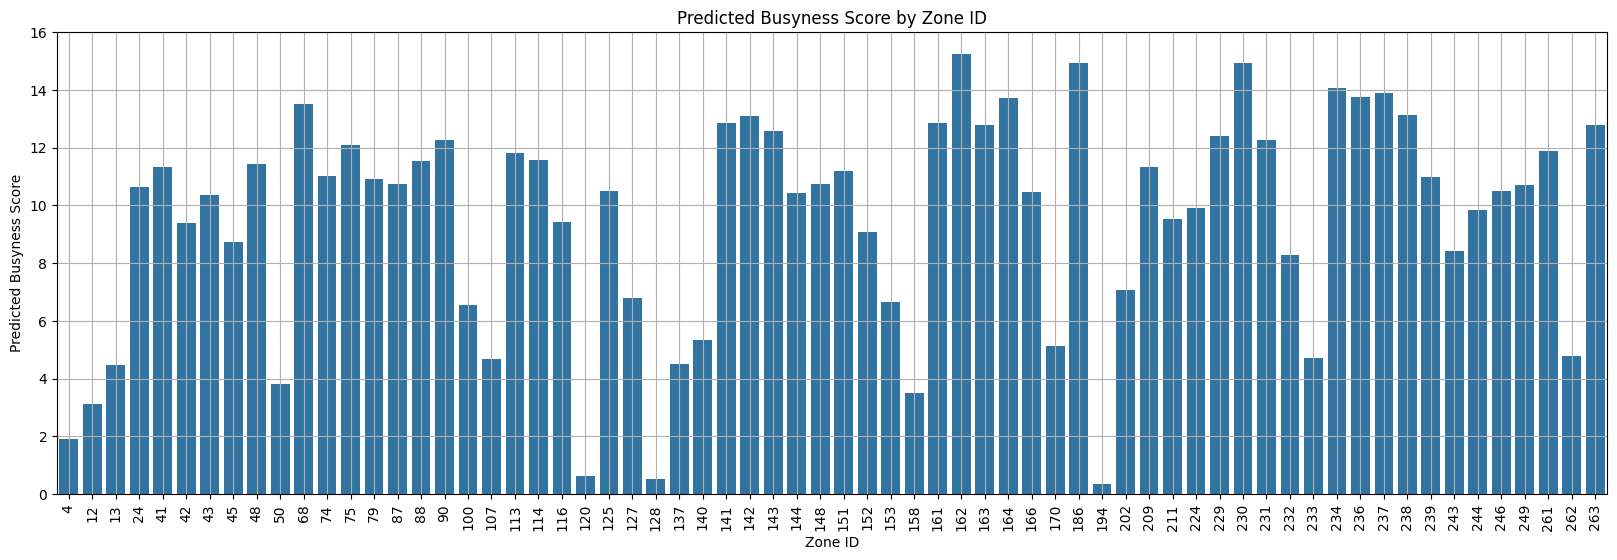

In [ ]:
#plot the busyness score vs zone id as a bar plot
plt.figure(figsize=(20, 6))
sns.barplot(x='zone_id', y='predicted_log_busyness_score', data=predictions)
plt.xticks(rotation=90)
plt.xlabel('Zone ID')
plt.ylabel('Predicted Busyness Score')
plt.title('Predicted Busyness Score by Zone ID')
plt.grid(True)
plt.show()


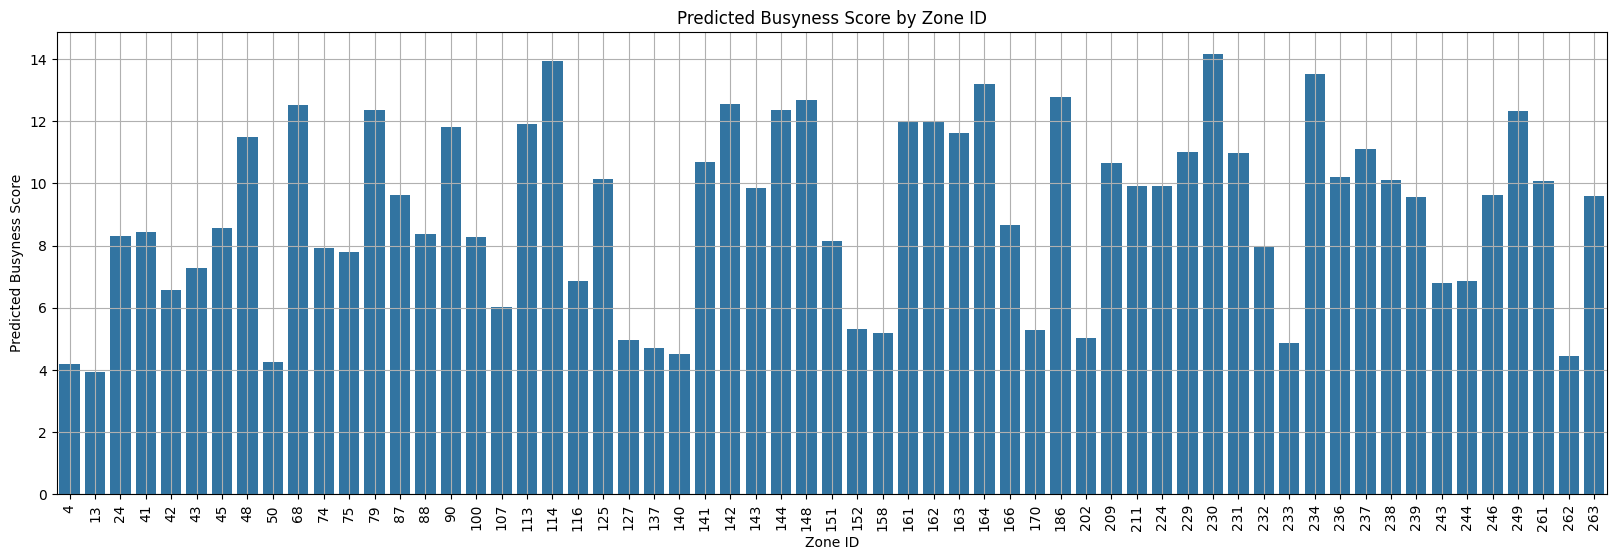

In [ ]:
sample = df[df['transit_timestamp'] == pd.Timestamp('2024-03-30 00:00:00')]
plt.figure(figsize=(20, 6))
#inverse
yy = (sample['log_busyness_score'])
sns.barplot(x='zone_id', y=yy, data=sample)
plt.xticks(rotation=90)
plt.xlabel('Zone ID')
plt.ylabel('Predicted Busyness Score')
plt.title('Predicted Busyness Score by Zone ID')
plt.grid(True)
plt.show()

In [ ]:
# Load the GeoJSON data containing the taxi zones.
with open('./NYC Taxi Zones.geojson') as f:
    geo_data = json.load(f)

In [ ]:
busyness_df = predictions.copy()

# Convert the relevant columns to string to ensure they match
busyness_df['zone_id'] = busyness_df['zone_id'].astype(str)

# Extract the features from the GeoJSON data and filter them based on the CSV file
features = [feature for feature in geo_data['features'] if feature['properties']['location_id'] in busyness_df['zone_id'].values]

# Create a DataFrame from the filtered GeoJSON features properties
gdf = pd.DataFrame([feature['properties'] for feature in features])

# Ensure that the 'location_id' and 'zone_id' columns are of the same type
gdf['location_id'] = gdf['location_id'].astype(str)

# Merge the GeoDataFrame with the busyness scores
gdf = gdf.merge(busyness_df, left_on='location_id', right_on='zone_id', how='left')

# Create a colormap with more steps for a sharper gradient
min_score = busyness_df['predicted_log_busyness_score'].min()
max_score = busyness_df['predicted_log_busyness_score'].max()
colormap = cm.LinearColormap(colors=['white', 'red'], vmin=min_score, vmax=max_score).to_step(n=30)

# Create a folium map centered around New York City
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Function to style the GeoJSON features
def style_function(feature):
    zone_id = feature['properties']['location_id']
    busyness_score = gdf.loc[gdf['location_id'] == zone_id, 'predicted_log_busyness_score']
    if not busyness_score.empty:
        fill_color = colormap(busyness_score.values[0])
    else:
        fill_color = 'grey'
    return {
        'fillOpacity': 0.7,
        'weight': 0.5,
        'fillColor': fill_color
    }


# Add the filtered GeoJSON data to the map with style and popups
folium.GeoJson(
    {"type": "FeatureCollection", "features": features},
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['location_id']),
    popup=folium.GeoJsonPopup(fields=['location_id'], aliases=['Zone ID:'])
).add_to(m)

# Add colormap to the map
colormap.add_to(m)

# show the map.
m
